In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import wcs
from astroquery.svo_fps import SvoFps
import numpy as np
import reproject
from astropy.visualization import simple_norm
basepath = '/orange/adamginsburg/jwst/sgrb2/NB/filter_subtractions'

In [ ]:
image_filenames_pipe ={
    "f150w": "/orange/adamginsburg/jwst/sgrb2/NB/F150W/pipeline/jw05365-o001_t001_nircam_clear-f150w-merged_i2d.fits", 
    "f182m": "/orange/adamginsburg/jwst/sgrb2/NB/F182M/pipeline/jw05365-o001_t001_nircam_clear-f182m-merged_i2d.fits", 
    "f187n": "/orange/adamginsburg/jwst/sgrb2/NB/F187N/pipeline/jw05365-o001_t001_nircam_clear-f187n-merged_i2d.fits", 
    "f210m": "/orange/adamginsburg/jwst/sgrb2/NB/F210M/pipeline/jw05365-o001_t001_nircam_clear-f210m-merged_i2d.fits", 
    "f212n": "/orange/adamginsburg/jwst/sgrb2/NB/F212N/pipeline/jw05365-o001_t001_nircam_clear-f212n-merged_i2d.fits", 
    "f300m": "/orange/adamginsburg/jwst/sgrb2/NB/F300M/pipeline/jw05365-o001_t001_nircam_clear-f300m-merged_i2d.fits",
    "f360m": "/orange/adamginsburg/jwst/sgrb2/NB/F360M/pipeline/jw05365-o001_t001_nircam_clear-f360m-merged_i2d.fits", 
    "f405n": "/orange/adamginsburg/jwst/sgrb2/NB/F405N/pipeline/jw05365-o001_t001_nircam_clear-f405n-merged_i2d.fits",
    "f410m": "/orange/adamginsburg/jwst/sgrb2/NB/F410M/pipeline/jw05365-o001_t001_nircam_clear-f410m-merged_i2d.fits", 
    "f466n": "/orange/adamginsburg/jwst/sgrb2/NB/F466N/pipeline/jw05365-o001_t001_nircam_clear-f466n-merged_i2d.fits", # weird, the filename is different from what is downloaded with the STScI pipeline...
    "f480m": "/orange/adamginsburg/jwst/sgrb2/NB/F480M/pipeline/jw05365-o001_t001_nircam_clear-f480m-merged_i2d.fits", 
}

In [3]:
# reproject to the longer wavelength filter
# if the filters have no overlap, use BB to scale the fluxes. Produce both scaled and unscaled version
# if there is an overlap, follow the formula and produce both images

In [4]:
def do_reproject(data_short, header_long):
    data_short_reprojected_long = reproject.reproject_exact(data_short, header_long)
    return data_short_reprojected_long

In [17]:
wavelength_table_wide = SvoFps.get_transmission_data('JWST/NIRCAM.f480m')
trans_wide = wavelength_table_wide['Transmission']
max(trans_wide)

0.39956

In [18]:
wavelength_table_wide = SvoFps.get_transmission_data('JWST/NIRCAM.f466n')
trans_wide = wavelength_table_wide['Transmission']
max(trans_wide)

0.329675

In [5]:
def subtract_filters(input1, input2):
    
    if input1[1:4] > input2[1:4]:
        long = input1
        short = input2
    else:
        long = input2
        short = input1

    fh_short = fits.open(image_filenames_pipe[short])
    fh_long = fits.open(image_filenames_pipe[long])

    # start by reprojecting to the longer wavelength
    print(f'Reprojecting the short wavelength filter ({short}) to the long wavelength filter ({long})')
    data_short_reprojected_long = do_reproject(fh_short['SCI'], fh_long['SCI'].header)[0] # moved the [0] here
    header_reprojected = fh_long['SCI'].header





    


    # determine which filter is narrow and which is wide:

    # both are the same
    if input1[4:] == input2[4:]:
        # scale the fluxes using BB
        wav_short = short[1:4]
        wav_long = long[1:4]
        scale_factor_short = (int(wav_short)/int(wav_long))**2
        data_long = fh_long['SCI'].data
        data_short = data_short_reprojected_long
        data_short_scaled = data_short_reprojected_long * scale_factor_short

        fits.PrimaryHDU(data=(data_long-data_short_scaled), header=header_reprojected).writeto(f'{basepath}/{long}_minus_{short}_scaled_BB.fits', overwrite=True)
        fits.PrimaryHDU(data=(data_long-data_short), header=header_reprojected).writeto(f'{basepath}/{long}_minus_{short}_unscaled.fits', overwrite=True)



        return
    elif (input1[4:] == 'w') | (input2[4:] == 'w'): # replace "or" with a vertical slash
        print('not yet supported')
        return
    elif input1[4:] == 'n':
        narrow = input1
        wide = input2
    elif input2[4:] == 'n':
        narrow = input2
        wide = input1
    else:
        print('There should be no need for this, but leaving for testing')

    if wide == long:
        data_wide = fh_long['SCI'].data
        data_narrow = data_short_reprojected_long
    elif wide == short:
        data_wide = data_short_reprojected_long
        data_narrow = fh_long['SCI'].data
    



    fh_narrow = fits.open(image_filenames_pipe[narrow])
    fh_wide = fits.open(image_filenames_pipe[wide])

    wavelength_table_narrow = SvoFps.get_transmission_data(f'JWST/NIRCAM.{narrow}')
    wavelength_table_wide = SvoFps.get_transmission_data(f'JWST/NIRCAM.{wide}')

    waves_wide = wavelength_table_wide['Wavelength']
    trans_narrow = np.interp(waves_wide, wavelength_table_narrow['Wavelength'], wavelength_table_narrow['Transmission'])
    trans_wide = wavelength_table_wide['Transmission']


    fractional_bandwidth = ( (trans_wide/trans_wide.max()) * (trans_narrow/trans_narrow.max()) ).sum() / (trans_wide/trans_wide.max()).sum()
    print(f'Fractional bandwidth: {fractional_bandwidth}')
    if fractional_bandwidth == 1:
        print("The filters either have no overlap or are identical. Exiting")
        return


    wide_minus_narrow = (data_wide - data_narrow * fractional_bandwidth) / (1-fractional_bandwidth)
    #return wide_minus_narrow
    print(f"Saving the wide_minus_narrow image as {wide}_minus_{narrow}.fits (continuum without line)") 
    fits.PrimaryHDU(data=wide_minus_narrow, header=header_reprojected).writeto(f'{basepath}/{wide}_minus_{narrow}.fits', overwrite=True)

    narrow_minus_wide = data_narrow - wide_minus_narrow
    print(f"Saving the narrow_minus_wide image as {narrow}_minus_{wide}.fits (line)")
    #return narrow_minus_wide
    fits.PrimaryHDU(data=narrow_minus_wide, header=header_reprojected).writeto(f'{basepath}/{narrow}_minus_{wide}.fits', overwrite=True)


In [6]:
subtract_filters('f212n', 'f210m')

Reprojecting the short wavelength filter (f210m) to the long wavelength filter (f212n)


Set DATE-AVG to '2024-09-07T14:47:53.656' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812695.827 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T08:12:05.282' from MJD-AVG.
Set DATE-END to '2024-09-07T08:58:01.156' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -5.013308 from OBSGEO-[XYZ].
Set OBSGEO-H to 1301138701.716 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Fractional bandwidth: 0.12872677256361836
Saving the wide_minus_narrow image as f210m_minus_f212n.fits (continuum without line)
Saving the narrow_minus_wide image as f212n_minus_f210m.fits (line)


In [7]:
subtract_filters('f182m', 'f187n')

Reprojecting the short wavelength filter (f182m) to the long wavelength filter (f187n)


Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T11:59:42.775' from MJD-AVG.
Set DATE-END to '2024-09-07T13:59:11.263' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.939008 from OBSGEO-[XYZ].
Set OBSGEO-H to 1300551270.825 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Fractional bandwidth: 0.09655212419159323
Saving the wide_minus_narrow image as f182m_minus_f187n.fits (continuum without line)
Saving the narrow_minus_wide image as f187n_minus_f182m.fits (line)


In [8]:
subtract_filters('f405n', 'f360m')

Reprojecting the short wavelength filter (f360m) to the long wavelength filter (f405n)


Set DATE-AVG to '2024-09-07T17:53:49.174' from MJD-AVG.
Set DATE-END to '2024-09-07T18:38:10.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.577917 from OBSGEO-[XYZ].
Set OBSGEO-H to 1297733228.988 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T10:44:37.117' from MJD-AVG.
Set DATE-END to '2024-09-07T12:26:08.056' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.939008 from OBSGEO-[XYZ].
Set OBSGEO-H to 1300551270.825 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Fractional bandwidth: 0.2707777891526461
Saving the wide_minus_narrow image as f360m_minus_f405n.fits (continuum without line)
Saving the narrow_minus_wide image as f405n_minus_f360m.fits (line)


In [9]:
subtract_filters('f182m', 'f210m')
subtract_filters('f182m', 'f360m')
subtract_filters('f210m', 'f410m')
subtract_filters('f182m', 'f480m')
subtract_filters('f210m', 'f480m')
subtract_filters('f182m', 'f410m')

Reprojecting the short wavelength filter (f182m) to the long wavelength filter (f210m)


Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T14:47:53.656' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812695.827 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Reprojecting the short wavelength filter (f182m) to the long wavelength filter (f360m)


Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T17:53:49.174' from MJD-AVG.
Set DATE-END to '2024-09-07T18:38:10.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.577917 from OBSGEO-[XYZ].
Set OBSGEO-H to 1297733228.988 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Reprojecting the short wavelength filter (f210m) to the long wavelength filter (f410m)


Set DATE-AVG to '2024-09-07T14:47:53.656' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812695.827 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T16:21:01.379' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Reprojecting the short wavelength filter (f182m) to the long wavelength filter (f480m)


Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T14:47:53.677' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812689.621 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Reprojecting the short wavelength filter (f210m) to the long wavelength filter (f480m)


Set DATE-AVG to '2024-09-07T14:47:53.656' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812695.827 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T14:47:53.677' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812689.621 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


Reprojecting the short wavelength filter (f182m) to the long wavelength filter (f410m)


Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T16:21:01.379' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/reproject/spherical_intersect/core.py:35: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [ ]:
subtract_filters

In [10]:
subtract_filters('f480m', 'f360m')

Reprojecting the short wavelength filter (f360m) to the long wavelength filter (f480m)


Set DATE-AVG to '2024-09-07T17:53:49.174' from MJD-AVG.
Set DATE-END to '2024-09-07T18:38:10.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.577917 from OBSGEO-[XYZ].
Set OBSGEO-H to 1297733228.988 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T14:47:53.677' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812689.621 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
subtract_filters('f466n', 'f480m')

Reprojecting the short wavelength filter (f466n) to the long wavelength filter (f480m)


Set DATE-AVG to '2024-09-07T08:12:05.311' from MJD-AVG.
Set DATE-END to '2024-09-07T08:58:01.156' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -5.013308 from OBSGEO-[XYZ].
Set OBSGEO-H to 1301138701.716 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T14:47:53.677' from MJD-AVG.
Set DATE-END to '2024-09-07T15:32:14.489' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.717158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298812689.621 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Fractional bandwidth: 0.07187287789097196
Saving the wide_minus_narrow image as f480m_minus_f466n.fits (continuum without line)
Saving the narrow_minus_wide image as f466n_minus_f480m.fits (line)


In [ ]:
subtract_filters('f405n', 'f410m')

KeyError: 'f460m'

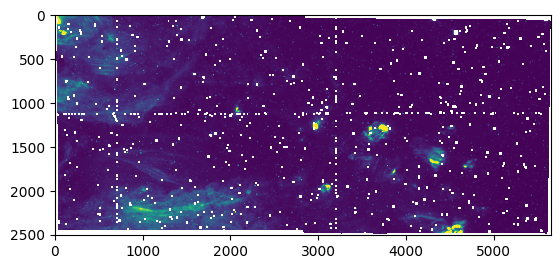

In [38]:
plt.imshow(test_narrow_minus_wide, vmin = 0, vmax = 100)

In [ ]:
subtract_filters('f182m', 'f187n')

Reprojecting the short wavelength filter (f182m) to the long wavelength filter (f187n)


Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T11:59:42.775' from MJD-AVG.
Set DATE-END to '2024-09-07T13:59:11.263' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.939008 from OBSGEO-[XYZ].
Set OBSGEO-H to 1300551270.825 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/blue/adamginsburg/nbudaiev/python_env/JWST_SgrB2/lib/python3.12/site-packages/reproject/common.py:170: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  return reproject_func(


In [ ]:
subtract_filters('f212n', 'f210m')